### Preprocessing con sostituzione dei valori nan

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import io
import requests

In [11]:
# URL completi dei file nel repository GitHub
thca_url = '../data/new_tcha_dataset.csv'
lusc_url = '../data/new_lusc_dataset.csv'
skcm_url = '../data/new_skcm_dataset.csv'
coadread_url = '../data/new_coadread_dataset.csv'

In [12]:
def checkNaN(row):
    tmp_idx = -1
    tmp_values = []
    
    for i, value in enumerate(row[1:], start=1):
        
        if pd.isna(value):
            if tmp_idx != -1:
                return pd.Series([None]*len(row), index=row.index)
            else:
                tmp_idx = i
        else:
            tmp_values.append(value)
    
    if tmp_idx != -1:
        row.iloc[tmp_idx] = np.mean(tmp_values)
                
    return row

In [13]:
def processing_ds(ds_url):
    #s = requests.get(ds_url).content
    #ds = pd.read_csv(io.StringIO(s.decode('utf-8')), sep='\t')
    ds = pd.read_csv(ds_url)
    
    #ds = ds.drop(columns='Hugo_Symbol', axis=1)
    #ds = ds[:10000]  # per fare prove 
    
    ds = ds.apply(checkNaN, axis=1) # Applica la funzione a ogni *riga* del df
    ds.dropna(inplace=True)
    
    file_name = ds_url.split('/')[-1].split('.')[0]       # nome del file dall'URL
    ds.to_csv(f'../data/clean_{file_name}.csv', index=False)

    # Verifica se il df contiene valori NaN lungo le righe
    if ds.isnull().any(axis=1).any():
        print("Il dataframe contiene valori NaN lungo le righe.")

    # Elimina geni che hnno lo stesso ID
    if ds.duplicated(subset=['Entrez_Gene_Id']).sum() > 0:
        ds = ds.drop_duplicates(subset=['Entrez_Gene_Id'])

    ds.reset_index(drop=True, inplace=True)

    return ds

In [14]:
ds_thca = processing_ds(thca_url)

In [15]:
ds_lusc = processing_ds(lusc_url)

In [16]:
ds_skcm = processing_ds(skcm_url)

In [17]:
ds_coadread = processing_ds(coadread_url)

### Trova i geni comuni

In [18]:
# Trova l'elenco dei geni comuni a tutti i dataset
common_genes = set(ds_coadread.iloc[:, 0]).intersection(set(ds_lusc.iloc[:, 0]), set(ds_skcm.iloc[:, 0]), set(ds_thca.iloc[:, 0]))

In [19]:
# Filtra ogni dataset lasciando solo i geni comuni
ds_coadread = ds_coadread[ds_coadread.iloc[:, 0].isin(common_genes)]
ds_lusc = ds_lusc[ds_lusc.iloc[:, 0].isin(common_genes)]
ds_skcm = ds_skcm[ds_skcm.iloc[:, 0].isin(common_genes)]
ds_thca = ds_thca[ds_thca.iloc[:, 0].isin(common_genes)]

### Correlation matrix per eliminaregeni con correlazione superiore a 0.9


In [9]:
def corr_matrix(ds):
    ds.set_index('Entrez_Gene_Id', inplace=True)
    
    # Calcola la matrice di correlazione tra i geni
    corr_matrix = ds.T.corr()

    return corr_matrix

In [10]:
def delete_rows(df, valori_da_eliminare):
    print("Numero geni da togliere:" , len(valori_da_eliminare))
    print("Lunghezza database prima di togliere geni:" , len(df))    
    df.reset_index(inplace=True)

    #x = ~df['Entrez_Gene_Id'].isin(valori_da_eliminare)
    #print(len(x))
    #print(x)
    
    # Filtrare il DataFrame per eliminare le righe con i valori specificati in 'entrez'
    df = df[~df['Entrez_Gene_Id'].isin(valori_da_eliminare)]

    print("Lunghezza database dopo aver tolto i geni:" , len(df)) 
    
    return df



In [11]:
def remove_genes(ds, threshold, count = 20):

    

    cm = corr_matrix(ds)  

    # Creiamo una copia della matrice di correlazione per lavorare sui valori
    significant_corr = cm.copy()

    # Imposta la diagonale su un valore non significativo per ignorarla
    np.fill_diagonal(significant_corr.values, 0)

    # Convertiamo la matrice in un DataFrame lungo (melted)
    melted_correlation = significant_corr.reset_index().melt(id_vars='Entrez_Gene_Id')

    # Filtriamo solo le coppie con un valore di correlazione maggiore della soglia
    filtered_pairs = melted_correlation[(melted_correlation['value'] > threshold) | (melted_correlation['value'] < - threshold)]

    # Rinominiamo le colonne per chiarezza
    filtered_pairs.columns = ['Gene1', 'Gene2', 'Correlation']

    # Visualizziamo i risultati
    #print(filtered_pairs)

    # Combinare Gene1 e Gene2 in un'unica serie e contare le frequenze
    all_genes = pd.concat([filtered_pairs['Gene1'], filtered_pairs['Gene2']])
    gene_counts = all_genes.value_counts()

    # Visualizziamo i risultati
    #print(gene_counts)

    # Creiamo il grafico delle frequenze dei geni
    plt.figure(figsize=(10, 6))
    gene_counts.plot(kind='bar')
    plt.xlabel('Genes')
    plt.ylabel('Frequency')
    plt.title('Distribution of Gene Frequencies in Filtered Pairs')
    plt.xticks(rotation=90)
    plt.show()

    # Prendere tutti i geni che hanno un count maggiore di COUNT e metterli in una lista
    genes_above_threshold = gene_counts[gene_counts > count].index.tolist()

    # Visualizziamo i geni sopra la soglia
    #print("Geni con count maggiore di 10:", genes_above_threshold)

    ds = delete_rows(ds, genes_above_threshold)  # Assuming delete_rows is defined elsewhere
    
    return ds


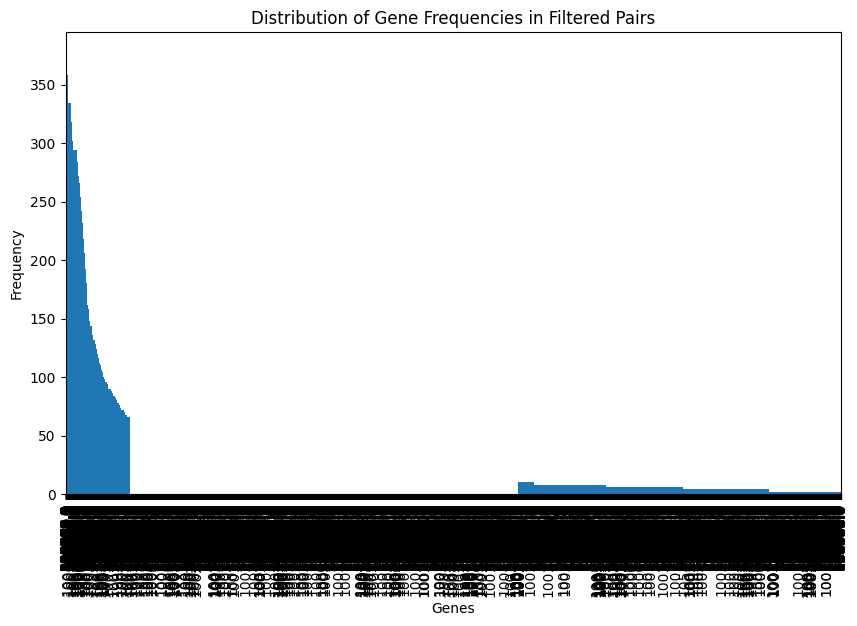

Numero geni da togliere: 9835
Lunghezza database prima di togliere geni: 20159
Lunghezza database dopo aver tolto i geni: 10324


In [12]:
dslusc_genesremoved = remove_genes(ds_lusc, 0.9)

# Salva il DataFrame come file CSV
dslusc_genesremoved.to_csv('../data/dslusc_genesremoved.csv', index=False)

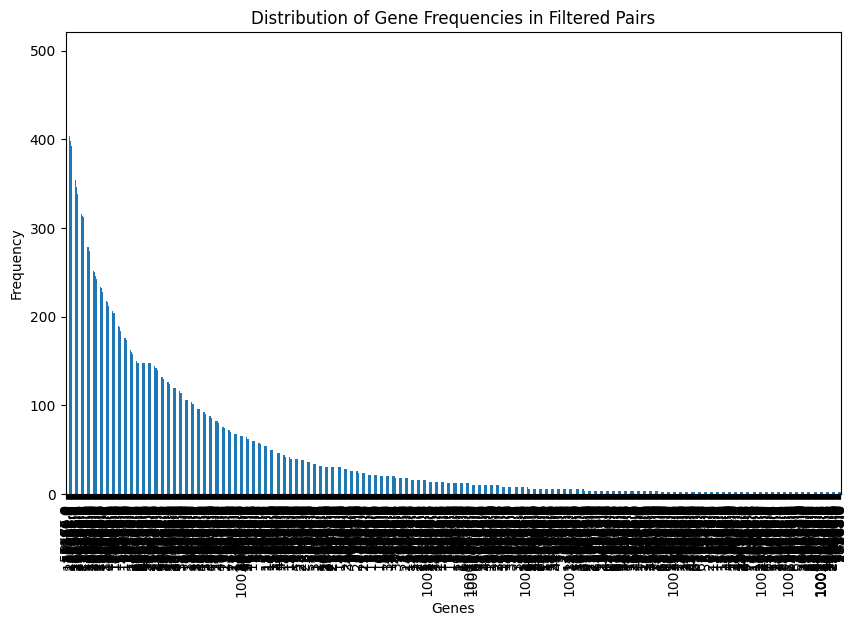

Numero geni da togliere: 872
Lunghezza database prima di togliere geni: 20023
Lunghezza database dopo aver tolto i geni: 19151


/tmp/ipykernel_74452/726780717.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.reset_index(inplace=True)


In [13]:
dsthca_genesremoved = remove_genes(ds_thca, 0.9)

# Salva il DataFrame come file CSV
dsthca_genesremoved.to_csv('../data/dsthca_genesremoved.csv', index=False)

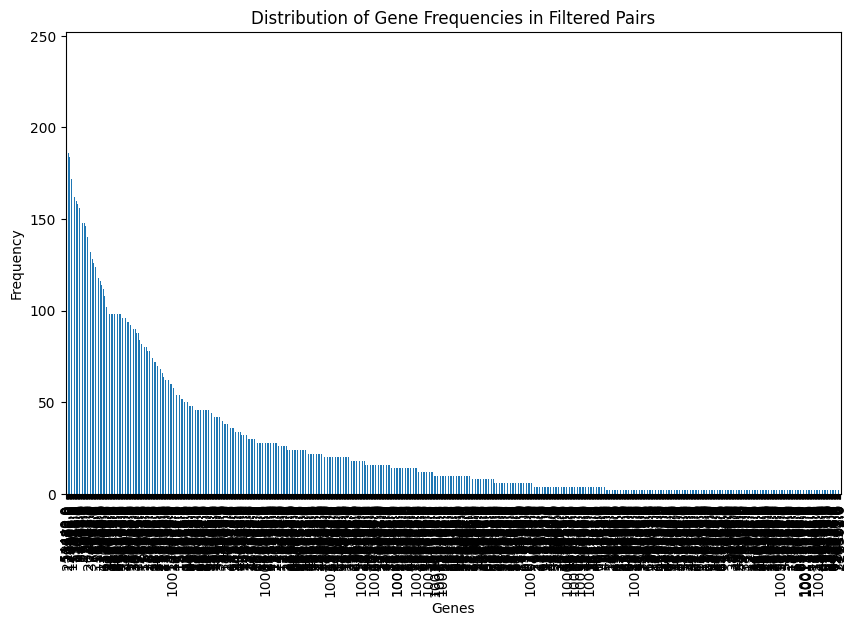

Numero geni da togliere: 598
Lunghezza database prima di togliere geni: 20151
Lunghezza database dopo aver tolto i geni: 19553


In [14]:
dsskcm_genesremoved = remove_genes(ds_skcm, 0.9)

# Salva il DataFrame come file CSV
dsskcm_genesremoved.to_csv('../data/dsskcm_genesremoved.csv', index=False)

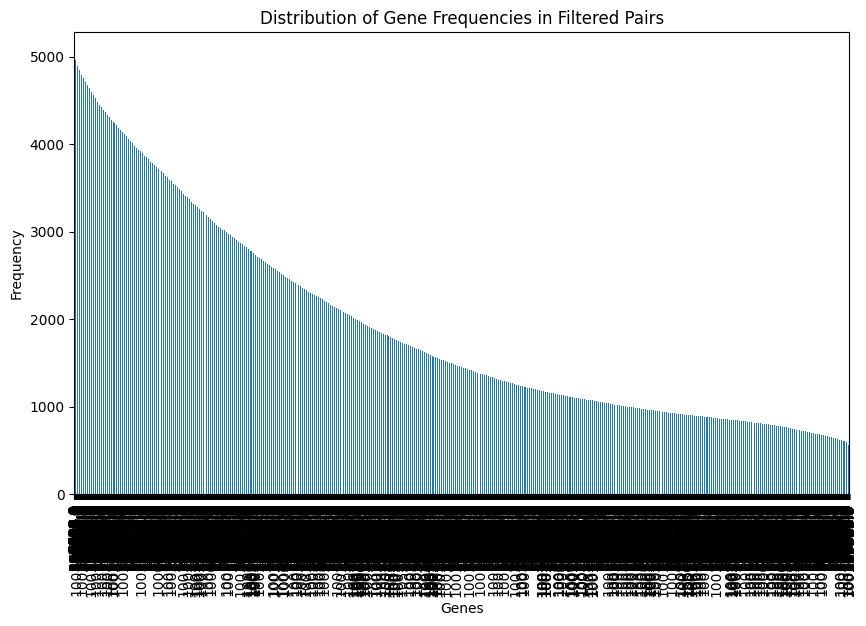

Numero geni da togliere: 17429
Lunghezza database prima di togliere geni: 17487
Lunghezza database dopo aver tolto i geni: 58


In [15]:
dsco_genesremoved = remove_genes(ds_coadread, 0.9)

# Salva il DataFrame come file CSV
dsco_genesremoved.to_csv('../data/dsco_genesremoved.csv', index=False)